# Initializing Gridmask 

In [ ]:
!pip install torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Helper Class 

In [ ]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

__all__ = ['get_mean_and_std', 'init_params', 'mkdir_p', 'AverageMeter']


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

def mkdir_p(path):
    '''make dir if not exist'''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


# GridMask Class - Use For Experiments 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import pdb
import math

class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
        if np.random.rand() > self.prob:
            return img
        h = img.size(1)
        w = img.size(2)
        
        # 1.5 * h, 1.5 * w works fine with the squared images
        # But with rectangular input, the mask might not be able to recover back to the input image shape
        # A square mask with edge length equal to the diagnoal of the input image 
        # will be able to cover all the image spot after the rotation. This is also the minimum square.
        hh = math.ceil((math.sqrt(h*h + w*w)))
        
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
        
        # maybe use ceil? but i guess no big difference
        self.l = math.ceil(d*self.ratio)
        
        mask = np.ones((hh, hh), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]

        mask = torch.from_numpy(mask).float().cuda()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        img = img * mask 

        return img

class GridMask(nn.Module):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        super(GridMask, self).__init__()
        self.rotate = rotate
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.grid = Grid(d1, d2, rotate, ratio, mode, prob)

    def set_prob(self, epoch, max_epoch):
        self.grid.set_prob(epoch, max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        n,c,h,w = x.size()
        y = []
        for i in range(n):
            y.append(self.grid(x[i]))
        y = torch.cat(y).view(n,c,h,w)
        return y



# Data Prefetch

In [ ]:
class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
        # With Amp, it isn't necessary to manually convert data to half.
        # if args.fp16:
        #     self.mean = self.mean.half()
        #     self.std = self.std.half()
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        # if record_stream() doesn't work, another option is to make sure device inputs are created
        # on the main stream.
        # self.next_input_gpu = torch.empty_like(self.next_input, device='cuda')
        # self.next_target_gpu = torch.empty_like(self.next_target, device='cuda')
        # Need to make sure the memory allocated for next_* is not still in use by the main stream
        # at the time we start copying to next_*:
        # self.stream.wait_stream(torch.cuda.current_stream())
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            # more code for the alternative if record_stream() doesn't work:
            # copy_ will record the use of the pinned source tensor in this side stream.
            # self.next_input_gpu.copy_(self.next_input, non_blocking=True)
            # self.next_target_gpu.copy_(self.next_target, non_blocking=True)
            # self.next_input = self.next_input_gpu
            # self.next_target = self.next_target_gpu

            # With Amp, it isn't necessary to manually convert data to half.
            # if args.fp16:
            #     self.next_input = self.next_input.half()
            # else:
            self.next_input = self.next_input.float()
            self.next_input = self.next_input.sub_(self.mean).div_(self.std)
            
    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        if input is not None:
            input.record_stream(torch.cuda.current_stream())
        if target is not None:
            target.record_stream(torch.cuda.current_stream())
        self.preload()
        return input, target


#Visualization - Classes are bugged 
I guess the Upsampling class refers to nn.Upsample

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

def show_mask_single(images, mask, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    def make_image(img, mean=(0,0,0), std=(1,1,1)):
      for i in range(0, 3):
          img[i] = img[i] * std[i] + mean[i]    # unnormalize
      npimg = img.numpy()
      return np.transpose(npimg, (1, 2, 0))


    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(2, 1, 1)
    plt.imshow(images.astype('uint8'))
    plt.axis('off')
"""
    # for b in range(mask.size(0)):
    #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
    mask_size = mask.size(2)
    # print('Max %f Min %f' % (mask.max(), mask.min()))
    mask = (nn.Upsample(mask, scale_factor=im_size/mask_size))
    # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
    # for c in range(3):
    #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

    # print(mask.size())
    mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
    # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
    plt.subplot(2, 1, 2)
    plt.imshow(mask)
    plt.axis('off')
"""

"\n    # for b in range(mask.size(0)):\n    #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())\n    mask_size = mask.size(2)\n    # print('Max %f Min %f' % (mask.max(), mask.min()))\n    mask = (nn.Upsample(mask, scale_factor=im_size/mask_size))\n    # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))\n    # for c in range(3):\n    #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]\n\n    # print(mask.size())\n    mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))\n    # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)\n    plt.subplot(2, 1, 2)\n    plt.imshow(mask)\n    plt.axis('off')\n"

In [ ]:
def show_mask(images, masklist, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    
    def make_image(img, mean=(0,0,0), std=(1,1,1)):
      for i in range(0, 3):
          img[i] = img[i] * std[i] + mean[i]    # unnormalize
      npimg = img.numpy()
      return np.transpose(npimg, (1, 2, 0))

    
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(1+len(masklist), 1, 1)
    plt.imshow(images)
    plt.axis('off')

    for i in range(len(masklist)):
        mask = masklist[i].data.cpu()
        # for b in range(mask.size(0)):
        #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
        mask_size = mask.size(2)
        # print('Max %f Min %f' % (mask.max(), mask.min()))
        mask = (nn.Upsample(mask, scale_factor=im_size/mask_size))
        # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
        # for c in range(3):
        #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

        # print(mask.size())
        #mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask)) #scale_factor 
        mask = make_image(torchvision.utils.make_grid(mask), Mean, Std)
        plt.subplot(1+len(masklist), 1, i+2)
        plt.imshow(mask)
        plt.axis('off')


# Download Examples

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

crop_size = 224
val_size = 256


transform = transforms.Compose(
    [transforms.RandomResizedCrop(crop_size),
    transforms.RandomHorizontalFlip(),])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def fast_collate(batch):
    imgs = [img[0] for img in batch]
    targets = torch.tensor([target[1] for target in batch], dtype=torch.int64)
    w = imgs[0].size[0]
    h = imgs[0].size[1]
    tensor = torch.zeros( (len(imgs), 3, h, w), dtype=torch.uint8 )
    for i, img in enumerate(imgs):
        nump_array = np.asarray(img, dtype=np.uint8)
        if(nump_array.ndim < 3):
            nump_array = np.expand_dims(nump_array, axis=-1)
        nump_array = np.rollaxis(nump_array, 2)

        tensor[i] += torch.from_numpy(nump_array)
        
    return tensor, targets

In [ ]:
  train_loader = torch.utils.data.DataLoader(
      trainset, pin_memory=True, collate_fn=fast_collate)

  val_loader = torch.utils.data.DataLoader(
      testset,
      pin_memory=True,
      collate_fn=fast_collate)

In [ ]:
 prefetcher = data_prefetcher(train_loader)
 input, target = prefetcher.next()

In [ ]:
grid = GridMask(32,64)
gimg = grid(input)

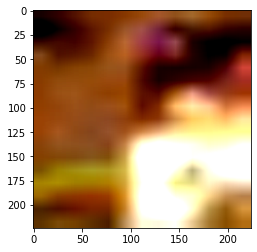

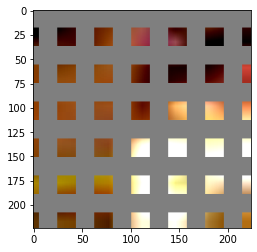

In [ ]:
imshow(torchvision.utils.make_grid(input.cpu()))
imshow(torchvision.utils.make_grid(gimg.cpu()))